In [11]:
import numpy as np
import sys

class NeuralNetMLP(object):
    
    """
    [Parameter]
     seed：乱数シード
     n_hidden：隠れユニットの個数
     l2：L2正規化のパラメータ
     epochs：トレーニングの試行回数
     eta：学習率
     shuffle：トレーニングごとにデータをシャッフルするかどうか
     minibatch_size：ミニバッチあたりのサンプル数
    
    """
    
    def __init__(self, n_hidden=30, l2=0.0, epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
        
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden # d
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def fit(self, X_train, y_train, X_valid, y_valid):
        
        n_output = np.unique(y_train).shape[0] #ラベル数:t=10
        n_features = X_train.shape[1] #Xの特徴量:m = 28×28 =784
        
        #隠れ層の定数
        self.b_h = np.zeros(self.n_hidden) #30×1
        #入力層から隠れ層への変換
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden)) # m×d (784×30)
        #出力層の定数
        self.b_out = np.zeros(n_output) #10×1
        #隠れ層から出力層への変換
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output)) # d×t(30×10)
        
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost':[], 'train_acc':[], 'valid_acc':[]}
        
        y_train_enc = self._onehot(y_train, n_output) #(y_train, 10) ⇒ 60000×10
        
        for i in  range(self.epochs):
            
            indices = np.arange(X_train.shape[0]) # [0, 1, 2, ・・・, 59999]
            
            if self.shuffle:
                self.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
            #0,100, 200, ・・・, 59800, 59900   
                batch_idx = indices[start_idx: start_idx + self.minibatch_size]
                #[0,1,2,・・・,100], [101,102,・・・,200], ・・・,[59900,599001,・・・,59999]
                
                #フォワードプロパゲーション
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                #バックプロパゲーション
                sigma_out = a_out - y_train_enc[batch_idx] # δout
                
                sigmoid_derivative_h = a_h * (1.0 - a_h) # dφ(z)/dz = ah(1-ah)
                
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h) # δh = δout * W *(dφ(z)/dz)
                
                #Δwh = δh * Ain + λWh
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h
                self.w_h -= self.eta*delta_w_h
                self.b_h -= self.eta*delta_b_h
                
                #Δwout = δout * Ah + λWout
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta*delta_w_out
                self.b_out -= self.eta*delta_b_out
                
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%%'
                             % (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self
            
    def predict(self, X):
        
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        
        return y_pred
        
        
    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0])) #((10, 600000))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.0
        
        return onehot.T # (60000, 10)
    
    
    def _forward(self, X):
        
        #隠れ層 X(60000)×30
        z_h = np.dot(X, self.w_h) + self.b_h
        
        #隠れ層出力 X(60000)×30
        a_h = self._sigmoid(z_h)
        
        #出力層 X(60000)×10
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        #出力層出力 X(60000)×10
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
        
               
    def _sigmoid(self, z):
        
        return 1.0 / (1.0 + np.exp(-np.clip(z, 250, 250)))
    
    
    def _compute_cost(self, y_enc, output):
        
        L2_term = (self.l2 * ( np.sum(self.w_h **2.0) + np.sum(self.w_out **2.0) ))
        term1 = -y_enc * (np.log(output + 1e-5))
        term2 = (1.0 - y_enc) * np.log(1.0 - output + 1e-5)
        cost = np.sum(term1 -term2) + L2_term
        
        return cost
        

In [12]:
import numpy as np

mnist = np.load('mnist_scales.npz')
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

In [48]:
import pandas as pd

indices = np.arange(X_train.shape[0])
minibatch_size=100

for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
#     print(start_idx)
    batch_idx = indices[start_idx: start_idx + minibatch_size]
#     print(batch_idx)

In [13]:
n_epochs=100
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=n_epochs, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)
nn.fit(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:])


100/100 | Cost: 52523270.73 | Train/Valid Acc.: 11.29%/10.60%

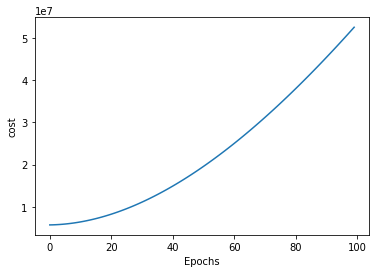

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.show()

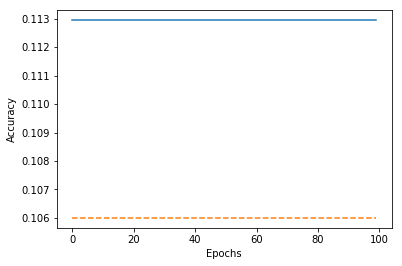

In [16]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [17]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float)/X_test.shape[0])
print('Test accuracy: %.2f%%' % (acc*100))

Test accuracy: 11.35%


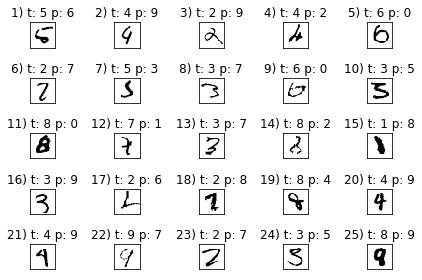

In [34]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax =ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()